# Simpson's Paradox


Simpson's Paradox is a classical case of data result **misinterpretation**. 

It arises when the result of a population ***appears*** to be in contradiction with that of its cohorts.  

If not treated correctly, this might mislead the analyst to draw the wrong conclusion.  

Understanding Simpson's Paradox is a great way to dip one's toes into *Causal Inference*.  

Here you will learn to resolve for Simpsons Paradox using `pgmpy` on a simulated case study.  


**Warning**  
Simpson's Paradox is mind bending 🤯 as it is non inuitive at first.  With that said ... it is worth the effort as it is the gateway drug to Causal Inference.  

In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference

## Imaginary Study

The premise is an imaginary, but plausible, pharma experiment on 2,000 sick patients that were equally distributed to two groups: 
* `control` - received a placebo
* `treatment` - received a trial drug   


The outcome is measured as binary: 
* `sick` - no change
* `recovered` - a positive change

A third parameter that is tracked is gender with values `male` and `female`. 


This a simple system of three binary variables:
* `Group` - the treatment variable
* `Outcome` - the target varaible 
* `Gender` - additional information




Note: All details of the problem and solution are detailed in [this slide deck](https://docs.google.com/presentation/d/1W-D9bZ5KMyuGGm9CsSRmQIPoxiMw03HFK7Rd10og9Ps/edit#slide=id.ge338c9a319_0_31). 


In the following we examine the distribution of the Recovery Rates (target variable ) according to the treatment variable `Group` as well as the `Gender` cohorts:   


![Screenshot 2021-10-12 at 08 42 47](https://user-images.githubusercontent.com/6064016/136913521-c389ebf5-def8-449f-95dc-9249bac6e942.png)

Here we see that the "Treatment - Control" Recovery Rate metric of the population is appears to contradict to those of its cohorts:  
* Total Population - `-14%`
* Males - `+10%`
* Females -  `+10%`


This means that one might infer two contradicting conclusions:   
* Conclusion 1:  The treatment has a **harmful effect** of absolute `-14%` on the whole population.  
* Conclusion 2:  The treatment has a **beneficial effect** of absolute `+10%` of the `male` and `female` cohorts.  

In other words the contradicting conclusions say that the drug is deleterious for the whole population but beneficial for the gender cohorts. 


This clearly does not make sense.  

To resolve this one needs to understand how the data was collect, or the story behind the data.  

## Story Behind The Data

The first step in causal inference is understanding the *story behind the data*.  

In detail we identify dependencies, e.g, which parameters are listening to which parameters?  

* `Gender` - is independent (this medical trial is simplistic, not gender changing ...)
* `Group` -  depends on on `Gender`.  
* `Outcome` - the Recovery Rate depends both on `Group` and `Gender`. 

As we see from the numbers above the study is not a randomised control trial.  
For some reason the males pertain 80% of the treatment group and only 20% of the control ...

![Screenshot 2021-10-12 at 08 43 03](https://user-images.githubusercontent.com/6064016/136918194-bdfb3d46-2ace-4ffe-90de-2b7930e28e8a.png)

The males recovery rate is also lower than that of the females (in both the `control` and `trial` groups).

Hence, the reason for Simpson's Paradox in this data is two-fold:
* The treatment varaible `Group` depends on `Gender`
* The outcome variable `Outcome` depends on `Gender`

The `Gender` parameter is a confounding factor, which means that information flows from `Group` to `Outcome` through it. To make sense of the results we need to adjust for the confounding `Gender`.

# DAG

Once we have the story behind the data, we viualise this in a Graph Model.  
Here we choose a [Directed Acyclic_Graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph).  

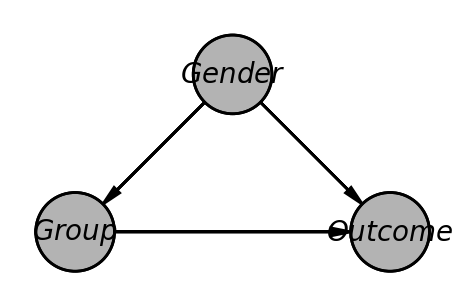

In [2]:
z_var = "Gender"
x_var = "Group"
y_var = "Outcome" 

model_ = BayesianNetwork([(z_var, x_var), (x_var, y_var), (z_var, y_var)])
model_.to_daft(node_pos={x_var: (0, 0), y_var: (2, 0), z_var: (1, 1)}).show(dpi=200)

# Conditional Probability Distributions

We first define that conditional probability distributions of the three parameters according to thier dependencies:

* *Gender*: $P(\text{Gender})$ - Gender is an independent variable
* *Group* : $P(\text{Group}|\text{Gender})$ - Group depends on Gender
* *Outcome*: $P(\text{Outcome}| \text{Gender}, \text{Group})$ - Outcome depends on both



$P(\text{Gender})$ - we assume a 50-50 split between the genders.


| Gender | $$P(\text{Gender})$$ |
| --- | --- |
| Male | 0.5 |
| Female | 0.5 |

In [3]:
# Gender definitions

male_frac_default = 0.5     # Gender split

z_0_name = "male"
z_1_name = "female"
z_names = [z_0_name, z_1_name]

male_frac = male_frac_default
female_frac = 1. - male_frac

z_values = [[male_frac],[female_frac]]

In [4]:
# Conditional Probability on Z

cpd_Z = TabularCPD(variable=z_var,
                   variable_card=len(z_names),
                   values=z_values,
                   state_names={z_var: z_names})

cpd_Z.values

array([0.5, 0.5])

$P(\text{Group}|\text{Gender})$ - This is the reason for Simpson's Paradox. Group depends on Gender and hence is a confounding factor. 

Each column contains the 100% for each cohort.  

| Group/Gender | Male|Female|
| --- | --- | --- |
| Control | 0.8 |0.2|
| Treatment | 0.2 |0.8|

In [5]:
x_0_name = "control"    # get placebo
x_1_name = "treatment"  # get the drug
x_names = [x_0_name, x_1_name]

x_values = [[0.2, 0.8], [0.8, 0.2]]

In [6]:
# Conditional Probability on X

cpd_X = TabularCPD(variable=x_var,
                   variable_card=len(x_names),
                   values=x_values,
                   evidence=[z_var],
                   evidence_card=[len(z_names)],
                   state_names={z_var: z_names, x_var:x_names})

cpd_X.values

array([[0.2, 0.8],
       [0.8, 0.2]])

$P(\text{Outcome}| \text{Gender}, \text{Group})$

Each column contains the 100% for each cohort.  

| Gender | Male|Male|Female|Female|
| --- | --- | --- |--- | --- |
| Outcome / Group | Control|Treatement|Control|Treatement|
| Sick | 0.6 |0.5|0.2 |0.1|
| Recovered | 0.4 |0.5|0.8|0.9|

In [7]:
y_0_name = "sick"
y_1_name = "recovered"
y_names = [y_0_name, y_1_name]

y_values = [[120./200, 400./800, 160./800, 20./200], [80./200, 400./800, 640./800, 180./200]]

In [8]:
cpd_Y = TabularCPD(variable=y_var,
                   variable_card=len(y_names),
                   values=y_values,
                   evidence=[z_var, x_var],
                   evidence_card=[len(z_names), len(x_names)],
                   state_names={z_var: z_names, x_var: x_names, y_var: y_names})

cpd_Y.values

array([[[0.6, 0.5],
        [0.2, 0.1]],

       [[0.4, 0.5],
        [0.8, 0.9]]])

In [9]:
# Adding CPDs to model

model_.add_cpds(cpd_Z, cpd_X, cpd_Y)

# Causal Inference

We demonstrate inference in two methods:

* Analytical - we use only the CPDs
* Empirical - we solve for random data generate according to the CPDs.

## Analytical 
Here we solve analytically directly from the CPDs. 

We demonstrate two use cases: 

* The correct method - using the Average Causal Effect (ACE; or ATE - Average Treatment Effect). This uses the *do* operator
* The incorrect method - we demonstrate the naïve method of using conditional probabilities which results in Simpson's Paradox --> i.e, misinterpretation.  

In [10]:
inference = CausalInference(model_)

### *Do* Operations

The *Do* operator is used to resolve for the *Group* confounding variable: 

$$P(\text{Outcome}|do(\text{Group}=\text{group_name}))$$


Here we calculate for both `group_name` values: `control` and `treatment`: 

* $P(\text{Outcome}|do(\text{Group}=\text{control}))$
* $P(\text{Outcome}|do(\text{Group}=\text{treatment}))$

We later calculate *ACE* as the difference between the rates when *Outcome=recovered*: 

$$ACE = \\ P(\text{Outcome=recovered}|do(\text{Group}=\text{treatment})) -  P(\text{Outcome=recovered}|do(\text{Group}=\text{control}))$$

In [11]:
print(f"{x_0_name} group:\t 𝑃(Outcome|𝑑𝑜(Group={x_0_name}))")
control_results = inference.query(variables=[y_var], do={x_var: x_0_name})
print(control_results)

print("-" * 40)

print(f"{x_1_name} group:\t 𝑃(Outcome|𝑑𝑜(Group={x_1_name}))")
treatment_results = inference.query(variables=[y_var], do={x_var: x_1_name})
print(treatment_results)

control group:	 𝑃(Outcome|𝑑𝑜(Group=control))


  0%|          | 0/2 [00:00<?, ?it/s]

+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.4000 |
+--------------------+----------------+
| Outcome(recovered) |         0.6000 |
+--------------------+----------------+
----------------------------------------
treatment group:	 𝑃(Outcome|𝑑𝑜(Group=treatment))


  0%|          | 0/2 [00:00<?, ?it/s]

+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.3000 |
+--------------------+----------------+
| Outcome(recovered) |         0.7000 |
+--------------------+----------------+


In [12]:
ACE = treatment_results.values[1] - control_results.values[1]
print(f"ACE = {treatment_results.values[1]:0.1f} - {control_results.values[1]:0.1f} = {ACE * 100:0.1f}%")

ACE = 0.7 - 0.6 = 10.0%


*... so what is the **do** operator?*

Generally speaking the *do* operator ensures the *ignorability* condition for causality: it ensures that all confounding factors are taken care of.

There are various conditions for which the *do* operator is useful. This is beyond the scope of this notebook, but for completeness we mention that the reader should learn about: 

* Backdoor Adjustment
* Frontdoor Adjustment

It is also worth mentioning that the *do* operator enables causality on the cohort level (e.g, all males within an age group of 35-45) as opposed to counterfactual which enable causality on the individual level (e.g, for your cousin who is male aged 36 years old). 


For completeness we mention that the *do* operator as used on the specific example of this notebook is the Backdoor Adjustment as defined as: 


$$P(Y=y|do(X=x)) \equiv \sum_zP(Y=y|X=x,Z=z)P(Z=z)$$

, where
* $Y$ is the *Outcome*
* $X$ is the *Group* 
* $Z$ is the *Gender*

Exanding this we obtain 

$P(Y=y|do(X=x)) =  P(Y=y|X=x,Z=z_0)P(Z=z_0) + P(Y=y|X=x,Z=z_1)P(Z=z_1)$

, where 
* $z_0$ is `male` and 
* $z_1$ is `female`

### Conditional Probabilities
An analysis that is limited to conditional probabilities without correcting for confounding varaibles results in **misinterpretation**.
 
 
 

$$P(\text{Outcome}|\text{Group}=\text{control})$$


Here we calculate for both `group_name` values: `control` and `treatment`: 

* $P(\text{Outcome}|\text{Group}=\text{control})$
* $P(\text{Outcome}|\text{Group}=\text{treatment})$

We later calculate the risk difference *RD* as the difference between the rates when *Outcome=recovered*: 

$$RD = \\ P(\text{Outcome=recovered}|\text{Group}=\text{treatment}) -  P(\text{Outcome=recovered}|\text{Group}=\text{control})$$


Note that the next cell contains the same `query` function as before, only we replace the `do` keyword with `evidence`: 

In [13]:
print(f"{x_0_name} group:\t 𝑃(Outcome|Group={x_0_name})")
control_rd_component = inference.query(variables=[y_var], evidence={x_var: x_0_name})
print(control_rd_component)

print("-" * 40)

print(f"{x_1_name} group:\t 𝑃(Outcome|Group={x_1_name})")
treatment_rd_component = inference.query(variables=[y_var], evidence={x_var: x_1_name})
print(treatment_rd_component)

control group:	 𝑃(Outcome|Group=control)
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.2800 |
+--------------------+----------------+
| Outcome(recovered) |         0.7200 |
+--------------------+----------------+
----------------------------------------
treatment group:	 𝑃(Outcome|Group=treatment)
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.4200 |
+--------------------+----------------+
| Outcome(recovered) |         0.5800 |
+--------------------+----------------+


In [14]:
RD_pop = treatment_rd_component.values[1] - control_rd_component.values[1]
print(f"population RD = {treatment_rd_component.values[1]:0.2f} - {control_rd_component.values[1]:0.2f} = {RD_pop * 100:0.1f}%")

population RD = 0.58 - 0.72 = -14.0%


> What is the difference between a probability with a *do* operator to a conditional probability?

The *do* operations manifest effects of intervention on data, by applying the story behind it.  
E.g, in our example `Gender` is a confounding variable that we want to adjust for. 

We can **intervene** on a variable in a model, we fix its value and by so change the system and the values of other variables of often change as a result.

When we **condition** on a variable, we change nothing. We merely narrow our focus to the subset of cases in which the variables takes the value we are interested in. What changes, then, is our perception about the world, not the world itself.

$P(Y=y|X=x)$ - (conditional probability) represents the population distribution of $Y$ among a **subset** of individuals whose $X$ value is $x$.

$P(Y=y|do(X=x))$ - represents the population distribution of $Y$ if **everyone** in the population had their $X$ value fixed at $x$. 


The do operation can manifests in observational data in what is called *graph surgery*.  
I.e, we simulate for a situation where a confounding variable (e.g, `Gender`) has no impact on treatment 
variable (e.g, `Group`).  

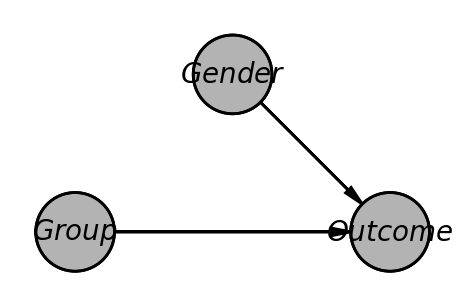

In [15]:
model_after_surgery = BayesianNetwork([(x_var, y_var), (z_var, y_var)])
model_after_surgery.to_daft(node_pos={x_var: (0, 0), y_var: (2, 0), z_var: (1, 1)}).show(dpi=200)

This graph illustrates this *surgery* because there is no arrow pointing from `Gender` to `Group`.  
In other words -  
by applying *do* operators we can simulate a randomised contrial trial condition on observational data.  

The advantage of this is that observational data is much more readily available whereas randomised control trials are expensive and time consuming.  

*Do*-expressions and graph surgery enable us to untangle the causal relationships from the correlative, including from observational data, assuming that 

* the graph constitutes a valid representation of reality
* no "side effects". i.e, assigning the value $x$ for the valuable $X$ for an individual does not alter subsequent variables in a direct way.

> I'm more comfortable with conditional probabilities than *do* operators, can I still use these to get causality?

Generally speaking, yes, you can, but it might be cumbersome.  
Here we show how you can calculate the same $ACE$ using conditional probabilities, but mind that this example has only three parameters. For systems with more (most likely scenario), it might be best to use *do* operators using `pgmpy` or other software.  



To obtain $ACE$ using conditional probability distributions we need to solve for: 

$ACE= \sum_{g=[\text{male, female}]}RD_{g} P(\text{Gender}=\text{g}) $

, where 


$RD_g = \\ P(\text{Outcome=recovered}|\text{Group}=\text{treatment}, \text{Gender}=\text{g}) - \\  P(\text{Outcome=recovered}|\text{Group}=\text{control},    \text{Gender}=\text{g})$



In [16]:
print(f"{z_0_name} {x_0_name}")
male_control = inference.query(variables=[y_var], evidence={x_var: x_0_name, z_var: z_0_name})
print(male_control)

print("-" * 40)

print(f"{z_0_name} {x_1_name}")
male_treatment = inference.query(variables=[y_var], evidence={x_var: x_1_name, z_var: z_0_name})
print(male_treatment)


male_rd = male_treatment.values[1] - male_control.values[1]
print(f"Male RD = {male_treatment.values[1]:0.2f} - {male_control.values[1]:0.2f} = {male_rd * 100.:0.1f}%")

male control
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.6000 |
+--------------------+----------------+
| Outcome(recovered) |         0.4000 |
+--------------------+----------------+
----------------------------------------
male treatment
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.5000 |
+--------------------+----------------+
| Outcome(recovered) |         0.5000 |
+--------------------+----------------+
Male RD = 0.50 - 0.40 = 10.0%


In [17]:
print(f"{z_1_name} {x_0_name}")
female_control = inference.query(variables=[y_var], evidence={x_var: x_0_name, z_var: z_1_name})
print(female_control)

print("-" * 40)

print(f"{z_1_name} {x_1_name}")
female_treatment = inference.query(variables=[y_var], evidence={x_var: x_1_name, z_var: z_1_name})
print(female_treatment)

female_rd = female_treatment.values[1] - female_control.values[1]
print(f"Female RD = {female_treatment.values[1]:0.2f} - {female_control.values[1]:0.2f} = {female_rd * 100.:0.1f}%")

female control
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.2000 |
+--------------------+----------------+
| Outcome(recovered) |         0.8000 |
+--------------------+----------------+
----------------------------------------
female treatment
+--------------------+----------------+
| Outcome            |   phi(Outcome) |
+====================+================+
| Outcome(sick)      |         0.1000 |
+--------------------+----------------+
| Outcome(recovered) |         0.9000 |
+--------------------+----------------+
Female RD = 0.90 - 0.80 = 10.0%


In [18]:
print(cpd_Z)

+----------------+-----+
| Gender(male)   | 0.5 |
+----------------+-----+
| Gender(female) | 0.5 |
+----------------+-----+


In [19]:
ACE_from_conditionals = male_rd * cpd_Z.values[0] + female_rd * cpd_Z.values[1] 

print(f"ACE (from conditaionals):\n= {male_rd:0.2f}*{cpd_Z.values[0]:0.2f} + {female_rd:0.2f}*{cpd_Z.values[1]:0.2f}\n= {100.*ACE_from_conditionals:0.1f}%") 

ACE (from conditaionals):
= 0.10*0.50 + 0.10*0.50
= 10.0%


## Simulated Data

Above we assumed that the conditional probability distributions are statistically significant. In reality, however, we would like to test this with empirical data (or simulated).


In the following we use the CPDs to generate simulated data to demonstrate how `pgmpy` can calculate the *ACE*. 

In [20]:
import numpy as np
import pandas as pd

In [21]:
n_population = 100000 #below 100000 examples we find at least a few percent differences in the simulated CPD from the expected, which might cause the ACE to be off

zs = np.random.choice([0,1], n_population, p=np.array(z_values).reshape([2]))

pd.Series(zs).value_counts(normalize=True)

1    0.5002
0    0.4998
dtype: float64

In [22]:
xs = []
for iz, z in enumerate(zs):
    p_x = x_values[z]
    xs.append(np.random.choice([0,1], 1, p=p_x)[0])

pd.Series(xs).value_counts(normalize=True)    

0    0.50007
1    0.49993
dtype: float64

In [23]:
ys = []
for z, x in zip(zs, xs):
    p_y = y_values[0][z * 2 + x]
    ys.append(np.random.choice([0,1], 1, p=[p_y, 1.-p_y])[0])

pd.Series(ys).value_counts(normalize=True)    

1    0.64719
0    0.35281
dtype: float64

In [24]:
data = pd.DataFrame({z_var: zs, x_var: xs, y_var: ys})

data.head(6)

,Gender,Group,Outcome
0,1,0,1
1,1,0,0
2,1,0,1
3,0,1,0
4,0,1,1
5,0,1,1


In [26]:
for gender in [0, 1]:
    for group in [0, 1]:
        cpd_y_expected = pd.Series(cpd_Y.values.T[group][gender])
        cpd_y_simulated = data.query(f"Gender == {gender} & Group == {group}")["Outcome"].value_counts(normalize=True)[[0, 1]]
        
        diff = (cpd_y_simulated[1] - cpd_y_expected[1]) / cpd_y_expected[1]
        
        print(cpd_y_expected)
        print(cpd_y_simulated)
        print(f"difference {diff * 100.:0.1f}%")
        
        print("-" * 20)
        
        

0    0.6
1    0.4
dtype: float64
0    0.611508
1    0.388492
Name: Outcome, dtype: float64
difference -2.9%
--------------------
0    0.5
1    0.5
dtype: float64
0    0.501961
1    0.498039
Name: Outcome, dtype: float64
difference -0.4%
--------------------
0    0.2
1    0.8
dtype: float64
0    0.201967
1    0.798033
Name: Outcome, dtype: float64
difference -0.2%
--------------------
0    0.1
1    0.9
dtype: float64
0    0.101668
1    0.898332
Name: Outcome, dtype: float64
difference -0.2%
--------------------


In [27]:
# ACE - Average Causal Effect; 
# ATE - Averge Treatment Effect

ace_simulated = inference.estimate_ate(x_var, y_var, data=data, estimator_type="linear")

print(f"ACE = {ace_simulated * 100:0.1f}%")

ACE = 10.5%


# Final Notes

Being Confused at this Stage is O.K. 🤯   


![Homer](https://media.giphy.com/media/3o6MbbwX2g2GA4MUus/giphy.gif "homer")


Credit: this giphy is pulled from [Giphy.com](https://giphy.com/gifs/season-3-the-simpsons-3x5-3o6MbbwX2g2GA4MUus).

## Lord's Paradox

Here we used binary data for all three parameters.  

Simpson's Paradox also arises for the case of continuous variables,  
which happens to known under the name *Lord's Paradox*.  

The following two illustrations help to gain an intuition.  

Imagine that the treatment variable is continuous (e.g, medicine in milligrams) as it the outcome (health score). 

<img src="https://user-images.githubusercontent.com/6064016/136919659-6bef4e4c-9397-42cf-84a4-aaa15c35f6b6.png" width = 300 />


The figure above shows that there appears to be a positive correlation between the two (red line). 

In the next figure we display the same imaginary (but plausible) data where we color code by the cohort (men, boys, girls and women): 

<img src="https://user-images.githubusercontent.com/6064016/136920301-5043296f-da85-4bff-9f6a-95439f27df30.png" width = 300 />

We now see that for all the cohorts the treatment is deleterious on the outcome (anti-correlation). 

Credit: this image was modified from the original version from [@infowetrust](https://infowetrust.com/).

## Mastering Simpson's Paradox 


Hopefully you have gained an appreciation for the importance of the paradox and how it may be avoided.  

Mastering Simpson's Paradox is crucial for adding Causal Inference to one's toolbox.


To do so I can suggest:

* [Simpson's Calculator](https://bit.ly/simpson-calculator) - an interactive demo of this setup to play with values to gain an intuition. 
* [Dagitty (dagitty.net)](http://dagitty.net/) - an interactive R web/desktop platform for causal inference in DAGs.
* [A Primer in Causal Inference](http://bayes.cs.ucla.edu/PRIMER/) - Judea Pearl's text book with excellent guiding exercizes to practice Simpson's Paradox.  

# Resources

* `pgmpy` algorithms based on [Causal Inference Tutorial](https://pgmpy.org/examples/Causal%20Inference.html).

* Simpson's Paradox values - based on [presentation example](https://docs.google.com/presentation/d/1W-D9bZ5KMyuGGm9CsSRmQIPoxiMw03HFK7Rd10og9Ps/edit#slide=id.ge338c9a319_0_31).

* [Simpson's Calculator](https://bit.ly/simpson-calculator) - an interactive demo

<img src="http://www.theagitator.net/wp-content/uploads/simpsonsparadox-470x363.jpg" />

Credit: This image is pulled from [The Agitator.net](http://www.theagitator.net/wp-content/uploads/simpsonsparadox-470x363.jpg)